# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [86]:
!pip install sklearn-crfsuite
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from tqdm import tqdm

model = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

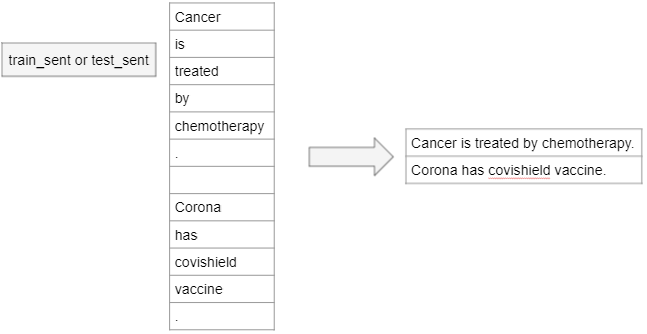

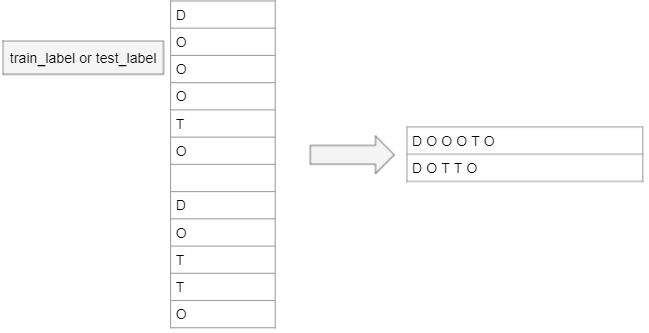

##EDA & Data Prep



---

### Loading the dataset(corpus) & pre-processing train & test datasets

In [87]:
# Useing "open" function to specify the dataset and action to perform and "readlines()" function will be used so that each sentence will be read as individual sentence:
with open('/content/train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('/content/train_label', 'r') as train_label_file:
  train_words_labels = train_label_file.readlines()

with open('/content/test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('/content/test_label', 'r') as test_label_file:
  test_words_labels = test_label_file.readlines()

In [88]:
# Defineing a function to form sentence as every word of a sentence in represented in seperate rows:
def word_stitch(data):
    stitch_list=[]
    word_stitch=""
    for word in data:
        if(word=='\n'):
            stitch_list.append(word_stitch)
            word_stitch=""
        else:
            word_stitch+=word.strip()+" "
    return stitch_list

In [89]:
# Creating proper sentence from words that were represented in each row useing the above function - "word_stitch":
train_sentences = word_stitch(train_words)
train_labels = word_stitch(train_words_labels)
test_sentences = word_stitch(test_words)
test_labels = word_stitch(test_words_labels)

In [90]:
print(train_sentences[0:5])
print(train_labels[0:5])
print('\n')
print(test_sentences[0:5])
print(test_labels[0:5])

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) ', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) ', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) ', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) ", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively ) "]
['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O ', 'O O O O O O O O O O O O O O O O O O O O O O O O O ', 'O O O O O O O O O O O O O O O ', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O ', 



### Count the number of sentences in the processed train and test dataset 

In [91]:
print('Sentences in processed train dataset:',len(train_sentences))
print('Sentences in processed test dataset:',len(test_sentences))

Sentences in processed train dataset: 2599
Sentences in processed test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [92]:
print('Lines of labels in processed train dataset:',len(train_labels))
print('Lines of labels in processed test dataset:',len(test_labels))

Lines of labels in processed train dataset: 2599
Lines of labels in processed test dataset: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [93]:
# Create a corpus of test and train useing ".copy()" & ".extend()" function:
assignment_sentences = train_sentences.copy()
assignment_sentences.extend(test_sentences)
print("Total sentences in assignment corpus", len(assignment_sentences))

Total sentences in assignment corpus 3655


In [94]:
# Creating a "for" function to extract Noun & PROPN PoS Tags by passing them tru a Spacy model and measureing time useing "tqdm" library:
pos_tags= []
search_words= []
for doc in tqdm(assignment_sentences):
  for token in model(doc):
    if token.pos_ in ['NOUN', 'PROPN']:
      search_words.append(token.text)
      pos_tags.append(token.pos_)

100%|██████████| 3655/3655 [00:27<00:00, 132.33it/s]


In [95]:
# Create a new dataframe with the words & tags extracted from above function:
pos_df = pd.DataFrame({'WORD': search_words, 'POS TAGS': pos_tags})

# Finding frequency of 'NOUN' & 'PROPN' from the new data set created:
print("Count of NOUN's are:", pos_df['POS TAGS'].value_counts()[0])
print("Count of PROPN's are:", pos_df['POS TAGS'].value_counts()[1])

Count of NOUN's are: 20646
Count of PROPN's are: 3677


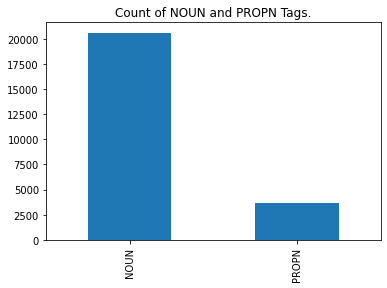

In [96]:
# Visualizing the frequecy of 'NOUN' & 'PROPN'
pos_df['POS TAGS'].value_counts().plot.bar()
plt.title('Count of NOUN and PROPN Tags.')
plt.show()

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [97]:
# Printing the the top 25 most common tokes with NOUN or PROPN PoS tags useing ".value_counts()" function.
pos_df['WORD'].value_counts().head(25)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          77
women            77
use              75
surgery          71
risk             71
cases            71
analysis         70
rate             67
response         66
dose             66
survival         65
children         64
Name: WORD, dtype: int64

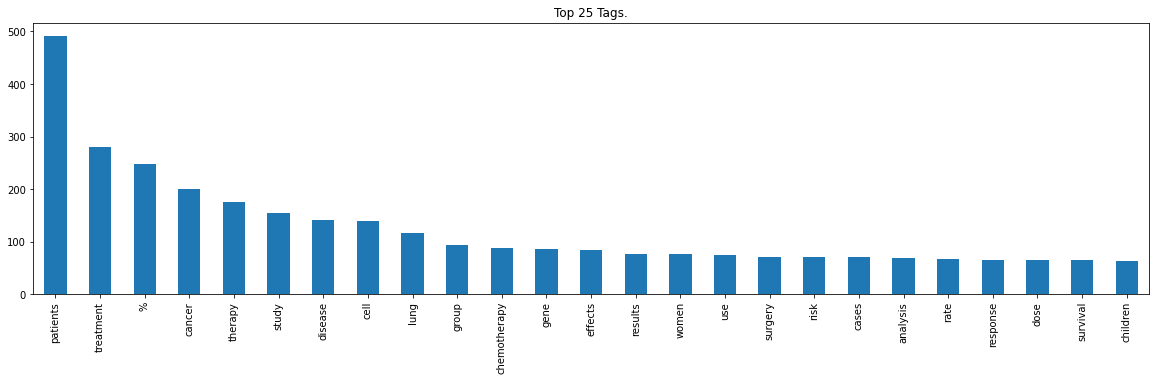

In [98]:
plt.figure(figsize=(20,5))
pos_df['WORD'].value_counts().head(25).plot.bar()
plt.title('Top 25 Tags.')
plt.show()

## Defining features for CRF





We have defined the following feature for CRF model building:


1.   f1 = input word is lower
2.   f2 = last 3 charecters of the word (ex - ing)
3.   f3 = last 2 charecters if the word (ex - es)
4.   f4 = Is the word in all uppercase
5.   f5 = IS the word a number
6.   f6 = Is the word starting with a capital letter
7.   f7 = Pos tag of the current word






In [99]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
 
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]
 
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 
 
  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence
 
  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [100]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [101]:
#testing the function "getFeaturesForOneSentence" on a sample sentence:
sample_sent = train_sentences[10]
print(sample_sent)

sample_feature = getFeaturesForOneSentence(sample_sent)
sample_feature[8]

A 2- , 3- , and 4-day mean temperature prior to the test date was compared to AFI using a Spearman-rank Correlation 


['word.lower=temperature',
 'word[-3:]=ure',
 'word[-2:]=re',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=mean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

### Write a code/function to get the labels of a sentence

In [102]:
# Write a code to get the labels for a sentence.
def getLabelsListForOneSentence(labels):
  return labels.split()

In [106]:
#testing the function "getLabelsListForOneSentence" on a sample labels:
sample_labels = train_labels[10]
print(sample_labels)
print('\n')
sample_feature_label = getLabelsListForOneSentence(sample_labels)
sample_feature_label[8]

O O O O O O O O O O O O O O O O O O O O O O 




'O'

## Define input and target variables


### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [107]:
x_train=[getFeaturesForOneSentence(sentence) for sentence in train_sentences]
x_test=[getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [108]:
y_train=[getLabelsListForOneSentence(labels) for labels in train_labels]
y_test=[getLabelsListForOneSentence(labels) for labels in test_labels]

In [109]:
print(x_train[200])
print(y_train[200])
print("\n")
print(x_test[30])
print(y_test[30])

[['word.lower=the', 'word[-3:]=The', 'word[-2:]=he', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=True', 'BEG'], ['word.lower=miracidia', 'word[-3:]=dia', 'word[-2:]=ia', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=the', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=True'], ['word.lower=of', 'word[-3:]=of', 'word[-2:]=of', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=miracidia', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=False'], ['word.lower=fasciola', 'word[-3:]=ola', 'word[-2:]=la', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=True', 'prev_word.lower=of', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=False'], ['word.lower=hepatica', 'word[-3:]=ica', 'word[-2:]=ca', 'word.isupper=False', 'word.isdigit=False', 'words.startsWi

## Build the CRF Model

In [119]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=200)

#crf.fit is throwing an error as sklearn version is above 0.23. We will pass "except" command for the Attribute Error to be passed.
try:
    crf.fit(x_train, y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [120]:
y_pred=crf.predict(x_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [121]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.907199602475757

In [122]:
index_sent = 599
print("Sentence:",test_sentences[index_sent])
print("True Labels:", y_test[index_sent])
print("Pred Labels:", y_pred[index_sent])

Sentence: Non-steroidal anti-inflammatory therapy for bronchial asthma 
True Labels: ['T', 'T', 'T', 'O', 'D', 'D']
Pred Labels: ['T', 'T', 'T', 'O', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

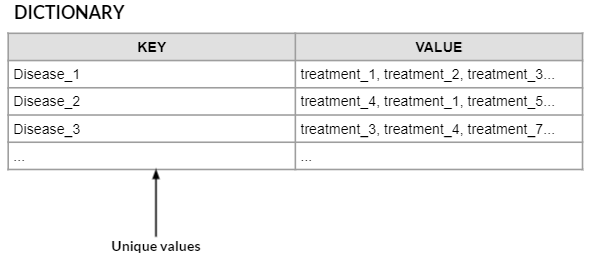

In [123]:
#function to get the predicted treatments (T) labels corresponding to each disease (D) label:
def get_diseaseTreatmentInfo(data):
    disease_treatment={}
    for index, sentence in enumerate(data):
        disease = []
        treatment = []
        for word_index, word in enumerate(sentence):
            if(word=='D'):
                disease.append(test_sentences[index].split()[word_index])
            if(word=='T'):
                treatment.append(test_sentences[index].split()[word_index])
        if(len(disease)>0 and len(treatment)>0):
            disease_treatment[' '.join(disease)] = treatment
    return disease_treatment


In [124]:
def dfDiseaseTreatment(disease_treatment): 
    return pd.DataFrame({"Disease":list(disease_treatment.keys()),"Treatments":disease_treatment.values()})

In [125]:
#Create the test data in a requisite dataframe format
dt = get_diseaseTreatmentInfo(y_pred)
df_dt_mapping = dfDiseaseTreatment(dt)
df_dt_mapping.head(5)

,Disease,Treatments
0,nonimmune hydrops fetalis,[Trisomy]
1,hereditary retinoblastoma,[radiotherapy]
2,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
3,coronary-artery disease,"[Antichlamydial, antibiotics]"
4,primary pulmonary hypertension ( PPH ),[fenfluramines]


In [126]:
# Convert the list format of Treatment column to string
df_dt_mapping["Treatments"] = df_dt_mapping["Treatments"].apply(lambda x:' , '.join(x))
df_dt_mapping.head(5)


,Disease,Treatments
0,nonimmune hydrops fetalis,Trisomy
1,hereditary retinoblastoma,radiotherapy
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,"Antichlamydial , antibiotics"
4,primary pulmonary hypertension ( PPH ),fenfluramines


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [129]:
disease='hereditary retinoblastoma'
print("The treatment for disease hereditary retinoblastoma  is: ", ' '.join(df_dt_mapping[df_dt_mapping['Disease'] == disease]['Treatments']))

The treatment for disease hereditary retinoblastoma  is:  radiotherapy
